# Import

In [1]:
import os
from datetime import datetime
from itertools import chain

import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DataLoader

In [4]:
class MyDataset(Dataset):
    def __init__(self, test_size=0.2, test=False):
        
        data_files = glob('../../brainmask_nii/*.nii')
        data_files.sort()
        
        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))
        
        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname  = [data_files[i] for i in shuffled_index[-test_num:]]
        
        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        
        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file.age_zscored.values[shuffled_index[-test_num:]]
            
        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file.age_zscored.values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        #print(idx)
        x = torch.tensor(nib.load(self.data_files[idx]).get_fdata())[None, :, :].float() / 255
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

train_dset = MyDataset()
test_dset  = MyDataset(test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

# 3D Convolution Model

## Modeling

In [5]:
class Conv3d(nn.Module):
    
    def __init__(self):
        super(Conv3d, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 5, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=3, stride=3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(8, 16, 5, 3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=3, stride=3)
        )
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [6]:
model = Conv3d().float()
model.to(device)

Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(3, 3, 3))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(3, 3, 3))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

## Debug

In [7]:
# for i, (x, y)in enumerate(test_loader):
#     if i < 1:
#         x = x.to(device)
#         y = y.to(device)
#         print(model.forward(x), y)
#     else:
#         break

## Passing through Model

In [8]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

In [9]:
epochs = range(20)

trn_losses, tst_losses = [], []

for e in epochs:
    
    trn_bth_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)
        
        loss = loss_fn(y_pred, y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()

        trn_bth_loss += loss.item()
        
        if not i % 20:
            print(f'{i:<4}th Batch. Loss: {loss.item():.3f}')

    torch.cuda.empty_cache()
    trn_losses.append(trn_bth_loss / len(train_loader))
        
        
    tst_bth_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)
            loss = loss_fn(y_pred, y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    tst_losses.append(tst_bth_loss / len(test_loader))
    torch.cuda.empty_cache()
    
    # Print
    print(f'EPOCHS {e} | TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0  th Batch. Loss: 0.333
20 th Batch. Loss: 1.148
40 th Batch. Loss: 1.168
60 th Batch. Loss: 0.373
80 th Batch. Loss: 1.161
100th Batch. Loss: 1.009


C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS 0 | TRAIN :: [LOSS] 1.100 | VALID :: [LOSS] 1.214
0  th Batch. Loss: 0.727
20 th Batch. Loss: 1.062
40 th Batch. Loss: 1.200
60 th Batch. Loss: 0.354
80 th Batch. Loss: 1.182
100th Batch. Loss: 0.922
EPOCHS 1 | TRAIN :: [LOSS] 1.026 | VALID :: [LOSS] 1.227
0  th Batch. Loss: 0.803
20 th Batch. Loss: 1.022
40 th Batch. Loss: 1.223
60 th Batch. Loss: 0.347
80 th Batch. Loss: 1.125
100th Batch. Loss: 0.731
EPOCHS 2 | TRAIN :: [LOSS] 1.025 | VALID :: [LOSS] 1.196
0  th Batch. Loss: 0.689
20 th Batch. Loss: 0.941
40 th Batch. Loss: 1.204
60 th Batch. Loss: 0.379
80 th Batch. Loss: 1.027
100th Batch. Loss: 0.644
EPOCHS 3 | TRAIN :: [LOSS] 1.012 | VALID :: [LOSS] 1.104
0  th Batch. Loss: 0.474
20 th Batch. Loss: 0.939
40 th Batch. Loss: 1.145
60 th Batch. Loss: 0.385
80 th Batch. Loss: 0.991
100th Batch. Loss: 0.646
EPOCHS 4 | TRAIN :: [LOSS] 0.998 | VALID :: [LOSS] 1.072
0  th Batch. Loss: 0.399
20 th Batch. Loss: 0.974
40 th Batch. Loss: 1.149
60 th Batch. Loss: 0.394
80 th Batch. Lo

# Plot Result

### Loss

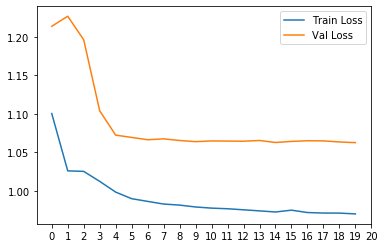

In [20]:
plt.plot(trn_losses)
plt.plot(tst_losses)
plt.legend(['Train Loss', 'Val Loss'])
plt.xticks(np.arange(0, 21, step=1))
plt.show()

### Regression Accuracy

In [15]:
def plot_result(trues, preds, title='Train', fname=None):
    preds = np.array(list(chain(*preds)))
    trues = np.array(list(chain(*trues)))
    
    cut = max(max(abs(preds)), max(abs(trues)))
    cuts = [-cut, cut]
              
    plt.scatter(preds, trues)
    plt.xlim(*cuts)
    plt.ylim(*cuts)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{title} Dataset Prediction')
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')
    if fname:
        plt.savefig(f'./result/{fname}_{title}.png')
    plt.show()

In [16]:
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}_lr{lr}'

### Train

In [13]:
model.eval()
train_true, train_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        train_pred.append(y_pred.to('cpu'))
        train_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

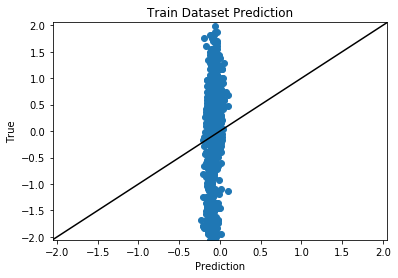

In [17]:
plot_result(train_true, train_pred, fname=fname)

### Test

In [18]:
model.eval()
test_true, test_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(test_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        test_pred.append(y_pred.to('cpu'))
        test_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

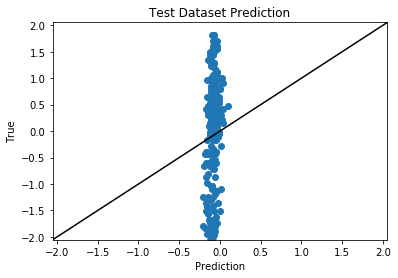

In [19]:
plot_result(test_true, test_pred, title='Test', fname=fname)